# 004.002 EDA - Goals

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import (extend_cols,
                                         vstacked_bar_charts,
                                         diagnose_discrete_fit)
from src.visualization.fit_dists import fit_nbinom

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

fn = '2007-2008__2017-2018.csv'
EDA_FP = PROJECT_DIR / 'data' / 'sample' / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

## Load Sample Data

Sample Data: Bundesliga Seasons 2007-2008 to 2014-2015

In [2]:
df_orig = pd.read_csv(EDA_FP, parse_dates=['date'])
df_orig = df_orig[~df_orig['season'].isin(['2015-2016', '2016-2017', '2017-2018'])]
cols = ['season', 'date', 'h', 'a', 'h_ftGoals', 'a_ftGoals', 'result']
df_orig = df_orig[cols].sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
df_orig.head(2)

,season,date,h,a,h_ftGoals,a_ftGoals,result
0,2007-2008,2007-08-10,stuttgart,schalke,2.0,2.0,draw
1,2007-2008,2007-08-11,bayern-munich,hansa-rostock,3.0,0.0,hwin


In [3]:
df_orig.tail(2)

,season,date,h,a,h_ftGoals,a_ftGoals,result
2446,2014-2015,2015-05-23,hoffenheim,hertha-berlin,2.0,1.0,hwin
2447,2014-2015,2015-05-23,paderborn,stuttgart,1.0,2.0,awin


In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 7 columns):
season       2448 non-null object
date         2448 non-null datetime64[ns]
h            2448 non-null object
a            2448 non-null object
h_ftGoals    2448 non-null float64
a_ftGoals    2448 non-null float64
result       2448 non-null object
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 134.0+ KB


## Review Goals

In [5]:
df = df_orig.copy(deep=True)
df[['h_ftGoals', 'a_ftGoals']].describe()

,h_ftGoals,a_ftGoals
count,2448.000000,2448.000000
mean,1.639706,1.259395
std,1.345841,1.188812
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,9.000000,8.000000


In [6]:

n_seasons = df['season'].unique().shape[0]
n_games_per_season = len(df) // n_seasons
h_goals = df['h_ftGoals'].dropna().astype(int)
a_goals = df['a_ftGoals']
# Need to deal with any goal value that has no occurrences in any game
# eg 2 games have 5 goals | 0 games have 6 goals | 1 game has 7 goals
# !! Important to do this every freq count
max_goals = int(df[['h_ftGoals', 'a_ftGoals']].max().max())
h_goals_val_counts = h_goals.value_counts()
h_goals_dist = h_goals.value_counts().sort_index(). \
                    reindex(range(max_goals+1), fill_value=0)

a_goals_val_counts_a = a_goals.value_counts()
a_goals_dist = a_goals.value_counts().sort_index(). \
                    reindex(range(max_goals+1), fill_value=0)

goals_dists = pd.concat([h_goals_dist, a_goals_dist], axis=1)

print(f'Home and Away Goals Distributions over {n_seasons} seasons with {n_games_per_season} games per season:\n\n{goals_dists}')

Home and Away Goals Distributions over 8 seasons with 306 games per season:

   h_ftGoals  a_ftGoals
0        515        747
1        761        837
2        609        511
3        328        235
4        160         84
5         51         24
6         16          8
7          5          1
8          2          1
9          1          0


In [7]:
h_goals_mean = df['h_ftGoals'].mean()
h_goals_var = df['h_ftGoals'].var()

a_goals_mean = df['a_ftGoals'].mean()
a_goals_var = df['a_ftGoals'].var()

print('Home Goals Distribution:\n')
print(f'Mean:\t\t{h_goals_mean}')
print(f'Variance:\t{h_goals_var}\n')

print('Away Goals Distribution:\n')
print(f'Mean:\t\t{a_goals_mean}')
print(f'Variance:\t{a_goals_var}\n')

Home Goals Distribution:

Mean:		1.6397058823529411
Variance:	1.811287530950231

Away Goals Distribution:

Mean:		1.2593954248366013
Variance:	1.4132749919202447



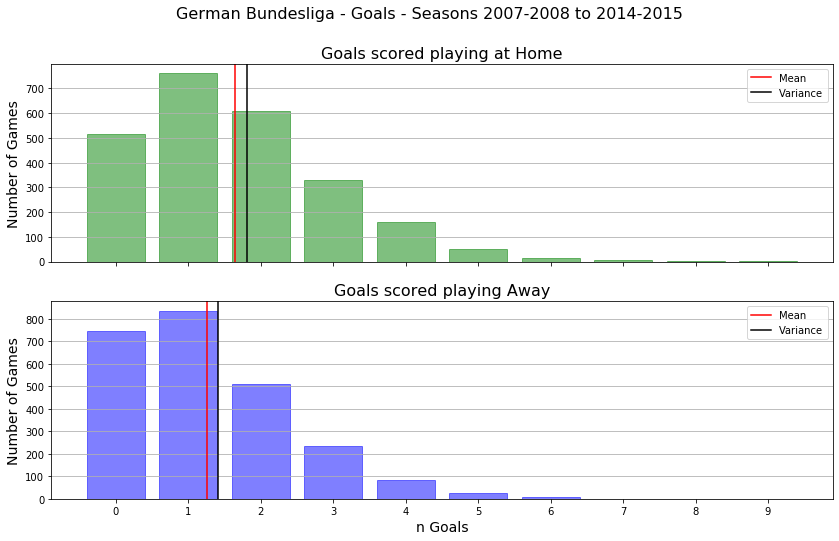

In [8]:
fig, (ax1, ax2) = vstacked_bar_charts(goals_dists.index, [goals_dists['h_ftGoals'], goals_dists['a_ftGoals']],
                                      figsize=(14,8))

ax1_bars = [rect.set_color('g') for rect in ax1.patches]
ax1.axvline(h_goals_mean, color='r', label='Mean')
ax1.axvline(h_goals_var, color='k', label='Variance')
ax1.set_title('Goals scored playing at Home', fontsize=16)
ax1.set_ylabel('Number of Games', fontsize=14)
ax1.yaxis.grid()
ax1.legend()

ax2_bars = [rect.set_color('b') for rect in ax2.patches]
ax2.axvline(a_goals_mean, color='r', label='Mean')
ax2.axvline(a_goals_var, color='k', label='Variance')
ax2.set_title('Goals scored playing Away', fontsize=16)
ax2.set_ylabel('Number of Games', fontsize=14)
ax2.set_xlabel('n Goals', fontsize=14)
ax2.yaxis.grid()

tick_spacing = 1
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.legend()
plt.suptitle('German Bundesliga - Goals - Seasons 2007-2008 to 2014-2015', fontsize=16)

plt.savefig(SAVED_IMAGES_DIR / 'eda-multiple-seasons-home-and-away-goals-barplots.PNG')
plt.show();

Red Lines shows mean

The [Home Advantage](https://dashee87.github.io/data%20science/python/home-advantage-in-football-leagues-around-the-world/) effect shows up clearly in the means

For a Poisson distribution to work, we are looking for the mean and variance of each distribution to be equal.

For both home and away games - variance > mean (But not by much!), so there is possibly some overdispersion

## Poisson Fit

### Home Goals Poisson Distribution Fit

Taking the mean to be equal to Poisson lambda parameter

In [9]:
# Get the expected values of a Poisson distribution with the same mu
norm_exp = stats.poisson.pmf(goals_dists.index, h_goals_mean)
exp = norm_exp * goals_dists['h_ftGoals'].sum()
h_goals_poiss = pd.DataFrame(np.vstack([goals_dists['h_ftGoals'].values, exp, norm_exp])).T
h_goals_poiss.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_goals_poiss['obs_norm'] = h_goals_poiss['obs']/ h_goals_poiss['obs'].sum()
h_goals_poiss

,obs,exp,exp_norm,obs_norm
0,515.0,475.002830,0.194037,0.210376
1,761.0,778.864934,0.318164,0.310866
2,609.0,638.554707,0.260848,0.248775
3,328.0,349.013970,0.142571,0.133987
4,160.0,143.070065,0.058444,0.065359
5,51.0,46.918565,0.019166,0.020833
6,16.0,12.822108,0.005238,0.006536
7,5.0,3.003498,0.001227,0.002042
8,2.0,0.615607,0.000251,0.000817
9,1.0,0.112157,0.000046,0.000408


In [10]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_goals_poiss['obs'],
                              f_exp=h_goals_poiss['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
ks = stats.kstest(h_goals_poiss['obs'],
                  'poisson',
                  [h_goals_mean])

print(f'Pearson:\n{chi2}\n')
print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=21.02548951056216, pvalue=0.007080026438162776)

KS:
KstestResult(statistic=0.7932291954531716, pvalue=3.143167601651894e-07)



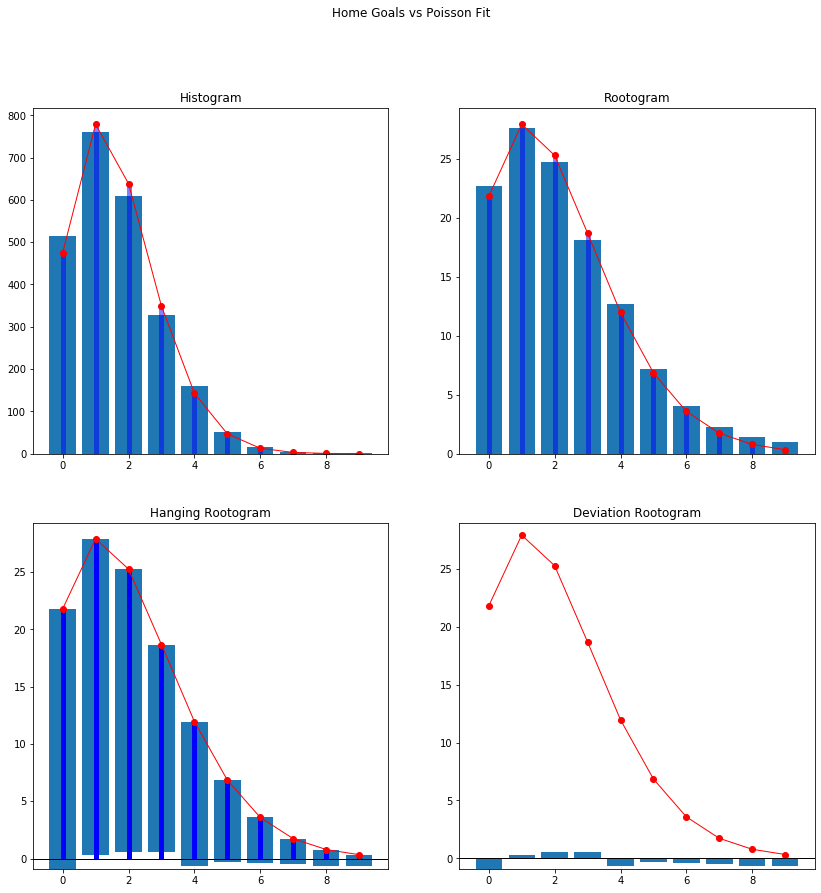

In [11]:
fig, axes = diagnose_discrete_fit(h_goals_poiss.index,
                                  h_goals_poiss['obs'],
                                  h_goals_poiss['exp'])
plt.suptitle('Home Goals vs Poisson Fit')

plt.savefig(SAVED_IMAGES_DIR / 'eda-home-goals-poisson-fit-diagnosisplots.PNG')
plt.show();

### Away Goals Poisson Distribution Fit

Taking the mean to be equal to Poisson lambda parameter

In [12]:
# Get the expected values of a Poisson distribution with the same mu
norm_exp = stats.poisson.pmf(goals_dists.index, a_goals_mean)
exp = norm_exp * goals_dists['a_ftGoals'].sum()
a_goals_poiss = pd.DataFrame(np.vstack([goals_dists['a_ftGoals'].values, exp, norm_exp])).T
a_goals_poiss.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
a_goals_poiss['obs_norm'] = a_goals_poiss['obs']/ a_goals_poiss['obs'].sum()
a_goals_poiss

,obs,exp,exp_norm,obs_norm
0,747.0,694.804992,0.283826,0.305147
1,837.0,875.034228,0.357449,0.341912
2,511.0,551.007052,0.225085,0.208742
3,235.0,231.311920,0.094490,0.095997
4,84.0,72.828293,0.029750,0.034314
5,24.0,18.343924,0.007493,0.009804
6,8.0,3.850376,0.001573,0.003268
7,1.0,0.692735,0.000283,0.000408
8,1.0,0.109053,0.000045,0.000408
9,0.0,0.015260,0.000006,0.000000


In [13]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(a_goals_poiss['obs'],
                              f_exp=a_goals_poiss['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
ks = stats.kstest(a_goals_poiss['obs'],
                  'poisson',
                  [a_goals_mean])

print(f'Pearson:\n{chi2}\n')
print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=23.898013543818276, pvalue=0.0023837722847193533)

KS:
KstestResult(statistic=0.6999928808849496, pvalue=1.9550139301973796e-05)



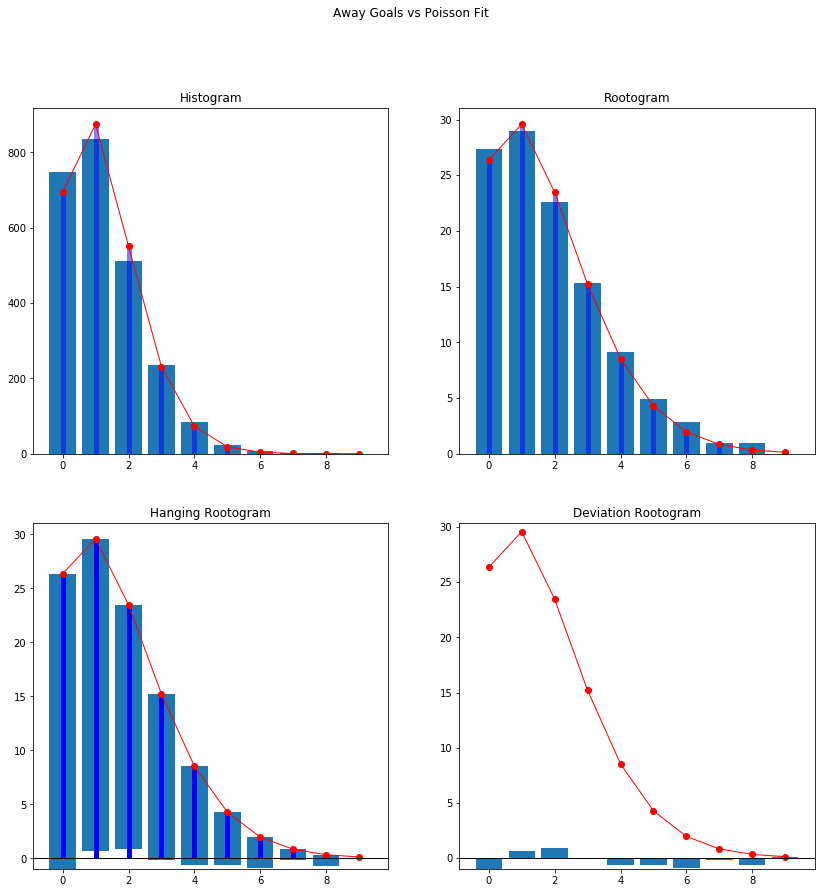

In [14]:
fig, axes = diagnose_discrete_fit(a_goals_poiss.index,
                                  a_goals_poiss['obs'],
                                  a_goals_poiss['exp'])
plt.suptitle('Away Goals vs Poisson Fit')

plt.savefig(SAVED_IMAGES_DIR / 'eda-away-goals-poisson-fit-diagnosisplots.PNG')
plt.show();

## Negative Binomial Fit

### Home Goals Negative Binomial Distribution Fit

In [15]:
# Fit the negative binomial to estimate the parameters
param_dict = fit_nbinom(df['h_ftGoals'])
print(param_dict)

{'size': 15.737578677184258, 'prob': 0.9056408452491791}


In [16]:
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
mean, var, skew, kurt = stats.nbinom.stats(param_dict['size'], param_dict['prob'], moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'h_goals_mean:\t{h_goals_mean}\th_goals_var:\t{h_goals_var}')

mean:		1.6397058829596725	variance:	1.8105476266461038
h_goals_mean:	1.6397058823529411	h_goals_var:	1.811287530950231


In [17]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp = stats.nbinom.pmf(goals_dists.index, param_dict['size'], param_dict['prob'])

exp = norm_exp * goals_dists['h_ftGoals'].sum()
h_goals_nbinom = pd.DataFrame(np.vstack([goals_dists['h_ftGoals'].values, exp, norm_exp])).T
h_goals_nbinom.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_goals_nbinom['obs_norm'] = h_goals_nbinom['obs']/ h_goals_nbinom['obs'].sum()
h_goals_nbinom

,obs,exp,exp_norm,obs_norm
0,515.0,514.520992,0.210180,0.210376
1,761.0,764.055761,0.312114,0.310866
2,609.0,603.353356,0.246468,0.248775
3,328.0,336.611427,0.137505,0.133987
4,160.0,148.787475,0.060779,0.065359
5,51.0,55.420991,0.022639,0.020833
6,16.0,18.074451,0.007383,0.006536
7,5.0,5.296175,0.002163,0.002042
8,2.0,1.420367,0.000580,0.000817
9,1.0,0.353491,0.000144,0.000408


In [18]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_goals_nbinom['obs'],
                              f_exp=h_goals_nbinom['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
print(f'Pearson:\n{chi2}\n')

Pearson:
Power_divergenceResult(statistic=3.157061725649787, pvalue=0.9241176767143519)



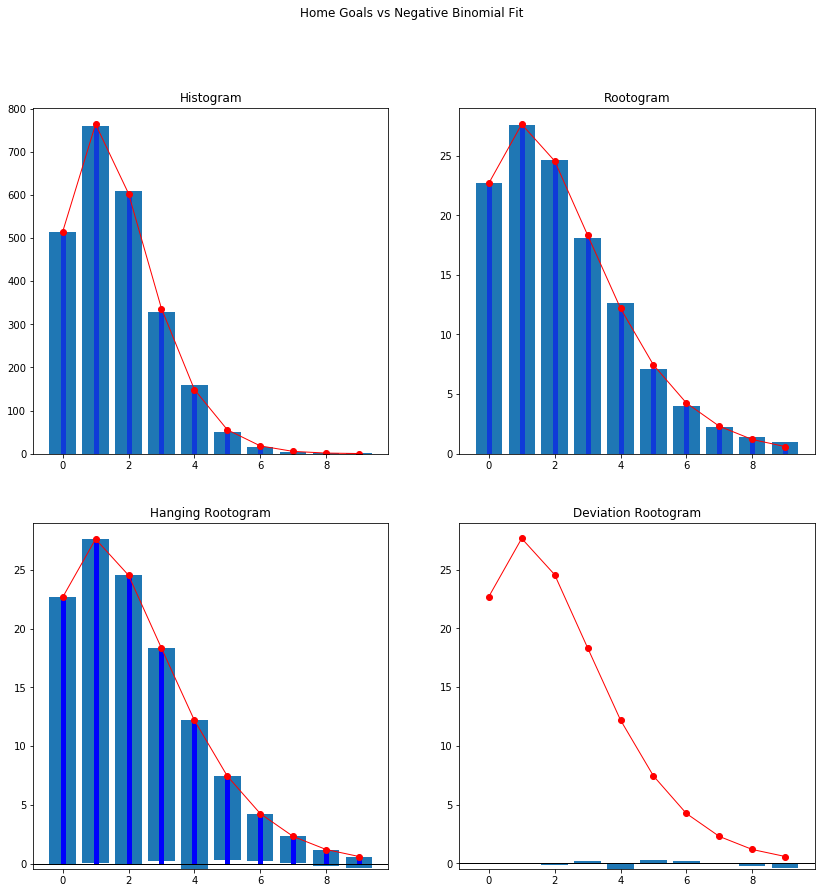

In [19]:
fig, axes = diagnose_discrete_fit(h_goals_nbinom.index,
                                  h_goals_nbinom['obs'],
                                  h_goals_nbinom['exp'])
plt.suptitle('Home Goals vs Negative Binomial Fit')

plt.show();

### Method 2 to estimate parameters

**Thinking about Negative Binomial Distributions**

We'll consider a negative binomial distribution like this.

+ An alternative to the Poisson Distribution where the variance of the distribution is greater than the mean

Simple Version of Method of Moments Estimators for Negative Binomial Parameters

$$ \hat p = \frac {\bar x}{s^2}$$

$$ \hat n = \frac {\bar x ^ 2}{s^2 - \bar x}$$

where:
+ $x$  is sample mean of the observed distribution
+ $s^2$ is the sample variance of the observed distribution

In [20]:
p = h_goals_mean/(h_goals_var)
n = h_goals_mean**2/ (h_goals_var - h_goals_mean)
param_dict = fit_nbinom(df['h_ftGoals'])

print(f'p:\t{p}')
print(f'n:\t{n}')

p:	0.9052708939550446
n:	15.66971411338511


In [21]:
print(f'Home Mean Goals:\t{h_goals_mean}')
print(f'Home Mean variance:\t{h_goals_var}\n')

mean, var, skew, kurt = stats.nbinom.stats(n, p, moments='mvsk')
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'h_goals_mean:\t{h_goals_mean}\th_goals_var:\t{h_goals_var}')

Home Mean Goals:	1.6397058823529411
Home Mean variance:	1.811287530950231

mean:		1.6397058823529411	variance:	1.811287530950231
h_goals_mean:	1.6397058823529411	h_goals_var:	1.811287530950231


In [22]:
# These look good for a lot less effort

In [23]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp2 = stats.nbinom.pmf(goals_dists.index, n, p)

exp2 = norm_exp2 * goals_dists['h_ftGoals'].sum()
h_goals_nbinom2 = pd.DataFrame(np.vstack([goals_dists['h_ftGoals'].values, exp2, norm_exp2])).T
h_goals_nbinom2.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_goals_nbinom2['obs_norm'] = h_goals_nbinom2['obs']/ h_goals_nbinom2['obs'].sum()
h_goals_nbinom2

,obs,exp,exp_norm,obs_norm
0,515.0,514.687668,0.210248,0.210376
1,761.0,763.991056,0.312088,0.310866
2,609.0,603.211856,0.246410,0.248775
3,328.0,336.559285,0.137483,0.133987
4,160.0,148.806771,0.060787,0.065359
5,51.0,55.454165,0.022653,0.020833
6,16.0,18.096760,0.007392,0.006536
7,5.0,5.306882,0.002168,0.002042
8,2.0,1.424554,0.000582,0.000817
9,1.0,0.354906,0.000145,0.000408


In [24]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_goals_nbinom2['obs'],
                              f_exp=h_goals_nbinom2['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
print(f'Pearson:\n{chi2}\n')

Pearson:
Power_divergenceResult(statistic=3.1505279752284587, pvalue=0.9245587936189162)



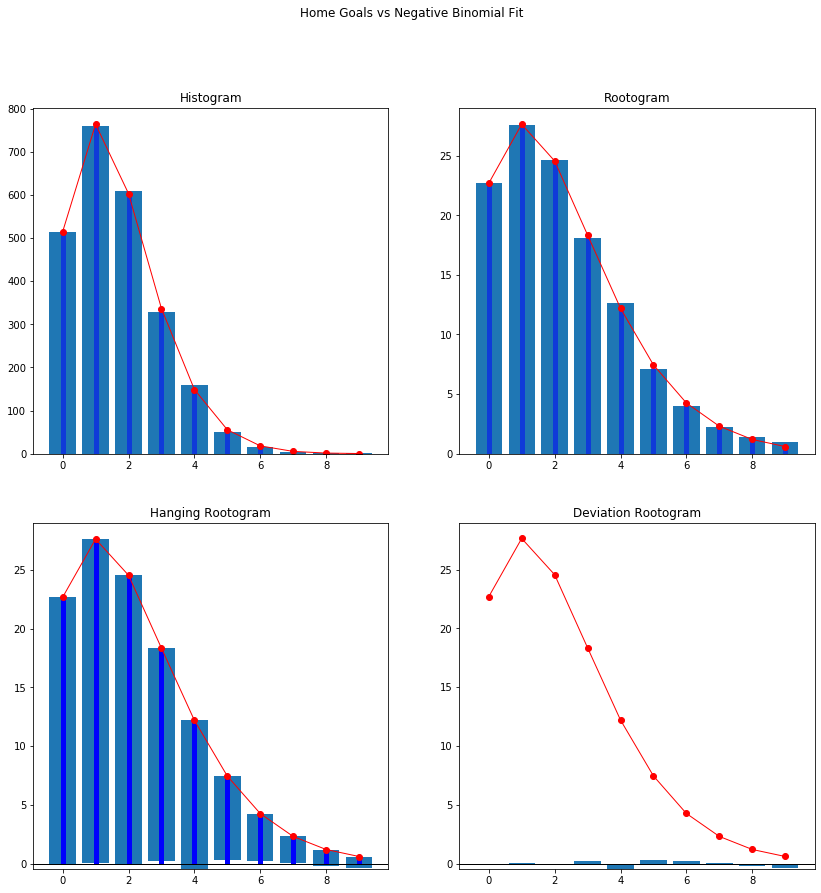

In [25]:
# plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(h_goals_nbinom2.index,
                                  h_goals_nbinom2['obs'],
                                  h_goals_nbinom2['exp'])
plt.suptitle('Home Goals vs Negative Binomial Fit')

plt.savefig(SAVED_IMAGES_DIR / 'eda-home-goals-negative-binomial-fit-diagnosisplots.PNG')
plt.show();

### Away Goals negative Binomial Fit

Use Simple Version of Method of Moments Estimators for Negative Binomial Parameters (Method 2)

$$ \hat p = \frac {\bar x}{s^2}$$

$$ \hat n = \frac {\bar x ^ 2}{s^2 - \bar x}$$

where:
+ $x$  is sample mean of the observed distribution
+ $s^2$ is the sample variance of the observed distribution

In [26]:
p = a_goals_mean/(a_goals_var)
n = a_goals_mean**2/ (a_goals_var - a_goals_mean)
param_dict = fit_nbinom(df['a_ftGoals'])

print(f'p:\t{p}')
print(f'n:\t{n}')

p:	0.891118453263958
n:	10.307260841442504


In [27]:
print(f'Away Mean Goals:\t{a_goals_mean}')
print(f'Away Mean variance:\t{a_goals_var}\n')

mean, var, skew, kurt = stats.nbinom.stats(n, p, moments='mvsk')
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'a_goals_mean:\t{a_goals_mean}\ta_goals_var:\t{a_goals_var}')

Away Mean Goals:	1.2593954248366013
Away Mean variance:	1.4132749919202447

mean:		1.2593954248366022	variance:	1.4132749919202459
a_goals_mean:	1.2593954248366013	a_goals_var:	1.4132749919202447


In [28]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp = stats.nbinom.pmf(goals_dists.index, n, p)

exp = norm_exp * goals_dists['a_ftGoals'].sum()
a_goals_nbinom = pd.DataFrame(np.vstack([goals_dists['a_ftGoals'].values, exp, norm_exp])).T
a_goals_nbinom.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
a_goals_nbinom['obs_norm'] = a_goals_nbinom['obs']/ a_goals_nbinom['obs'].sum()
a_goals_nbinom

,obs,exp,exp_norm,obs_norm
0,747.0,746.075717,0.304769,0.305147
1,837.0,837.298770,0.342034,0.341912
2,511.0,515.421049,0.210548,0.208742
3,235.0,230.227174,0.094047,0.095997
4,84.0,83.394910,0.034067,0.034314
5,24.0,25.982463,0.010614,0.009804
6,8.0,7.217401,0.002948,0.003268
7,1.0,1.830704,0.000748,0.000408
8,1.0,0.431232,0.000176,0.000408
9,0.0,0.095509,0.000039,0.000000


In [29]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(a_goals_nbinom['obs'],
                              f_exp=a_goals_nbinom['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
print(f'Pearson:\n{chi2}\n')

Pearson:
Power_divergenceResult(statistic=1.6012516117114965, pvalue=0.9908961264378234)



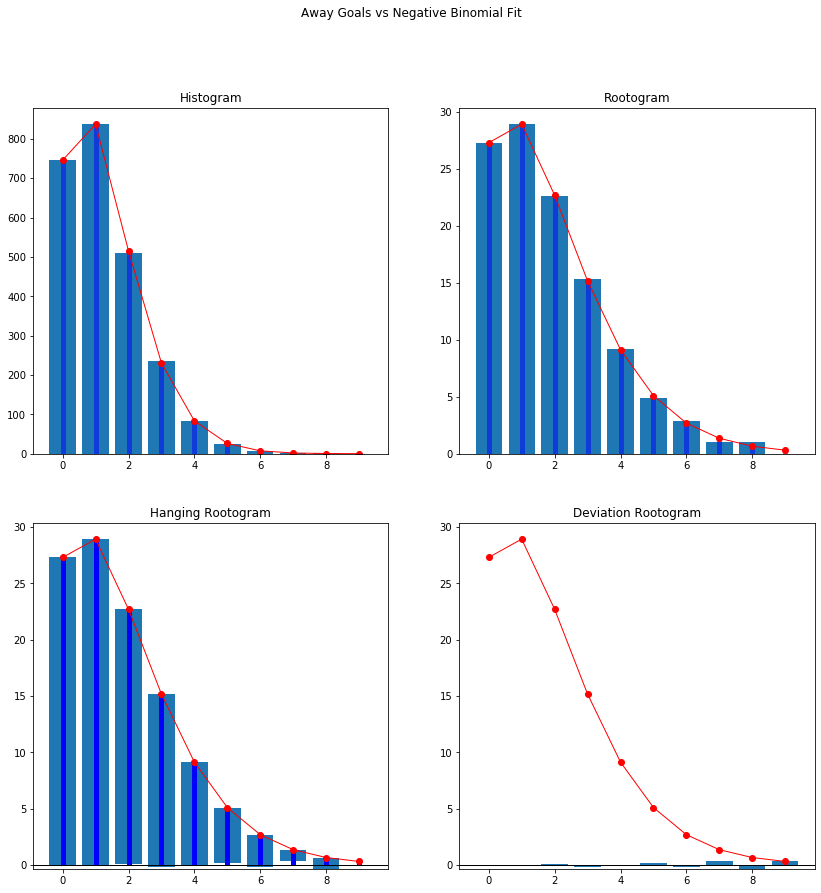

In [30]:
# plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(a_goals_nbinom.index,
                                  a_goals_nbinom['obs'],
                                  a_goals_nbinom['exp'])
plt.suptitle('Away Goals vs Negative Binomial Fit')

plt.savefig(SAVED_IMAGES_DIR / 'eda-away-goals-negative-binomial-fit-diagnosisplots.PNG')
plt.show();

### References

Visualizing Categorical Data by Michael Friendly - Copyright SAS Institute - ISBN 1-58025-660-0

https://stats.stackexchange.com/questions/78139/how-to-know-if-a-data-follows-a-poisson-distribution-in-r

https://stats.stackexchange.com/questions/328803/python-test-if-my-data-follow-a-poisson-exponential-distribution

https://blogs.sas.com/content/iml/2012/04/12/the-poissonness-plot-a-goodness-of-fit-diagnostic.html

https://github.com/gokceneraslan/fit_nbinom/blob/master/fit_nbinom.py